# 1. Setup

## 1.1 Install Dependencies

In [2]:
!pip install tensorflow == 2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

zsh:1: = not found


## 1.2 Import Dependencies

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [8]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [33]:
 !tar -xf lfw.tgz

In [10]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

NotADirectoryError: [Errno 20] Not a directory: 'lfw/.DS_Store'

## 2.2 Collect Positive and Anchor Classes

In [11]:
# Import uuid library to generate unique image names
import uuid

In [12]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/3cb17978-1e58-11ee-902f-e257b528affc.jpg'

In [48]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[50:180+250,50:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

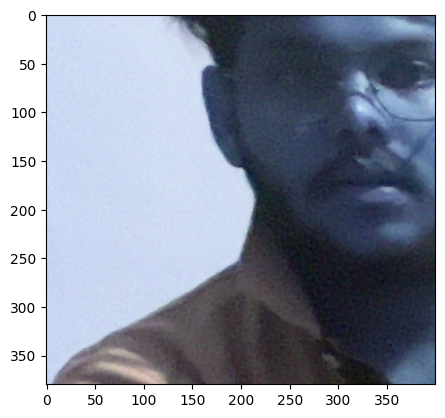

In [21]:
plt.imshow(frame)

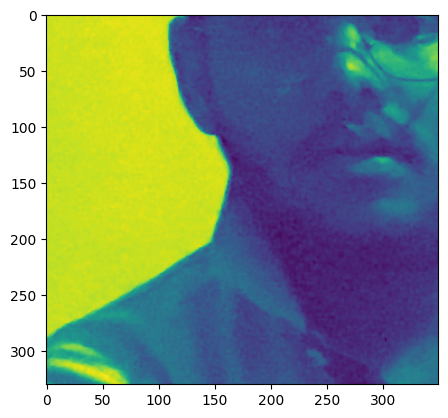

In [22]:
plt.imshow(frame[50:180+250,50:200+250, :1])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [31]:
print(dir_test.next())

b'data/anchor/f87debee-1dab-11ee-9b29-e257b528affb.jpg'


## 3.2 Preprocessing - Scale and Resize

In [32]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [33]:
img = preprocess('data/anchor/f87debee-1dab-11ee-9b29-e257b528affb.jpg')

In [34]:
img.numpy().max() 

0.9678432

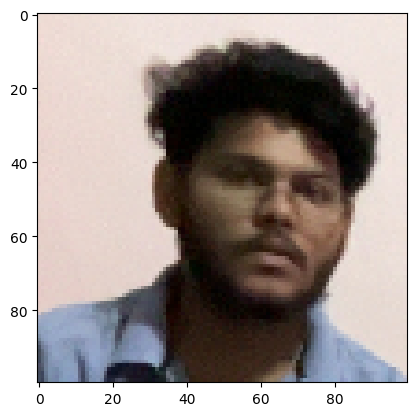

In [35]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [36]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [37]:
samples = data.as_numpy_iterator()

In [38]:
example = samples.next()

In [39]:
example

(b'data/anchor/ffcd6cbc-1dab-11ee-9b29-e257b528affb.jpg',
 b'data/positive/f877ab34-1dac-11ee-9b29-e257b528affb.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [40]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [41]:
res = preprocess_twin(*example)

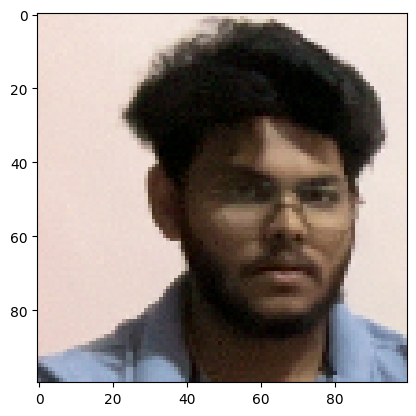

In [42]:
plt.imshow(res[1])

In [43]:
res[2]

1.0

In [44]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [45]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [46]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer


In [47]:
inp = Input(shape=(100,100,3), name='input_image')

c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [48]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [49]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [50]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer


In [51]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [52]:
l1 = L1Dist()

In [53]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [54]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [55]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [56]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)


In [57]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [58]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## 4.3 Make Siamese Model

In [59]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [60]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training


## 5.1 Setup Loss and Optimizer


In [61]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.legacy.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints


In [62]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function


In [63]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

In [64]:
y

array([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [65]:
tf.losses.BinaryCrossentropy??

In [66]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop


In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [99]:
EPOCHS = 20

In [100]:
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 72s 3s/step

 Epoch 2/20
27/27 [==============================] - 75s 3s/step

 Epoch 3/20
27/27 [==============================] - 77s 3s/step

 Epoch 4/20
27/27 [==============================] - 78s 3s/step

 Epoch 5/20
27/27 [==============================] - 79s 3s/step

 Epoch 6/20
27/27 [==============================] - 80s 3s/step

 Epoch 7/20
27/27 [==============================] - 85s 3s/step

 Epoch 8/20
27/27 [==============================] - 83s 3s/step

 Epoch 9/20
27/27 [==============================] - 81s 3s/step

 Epoch 10/20
27/27 [==============================] - 84s 3s/step

 Epoch 11/20
27/27 [==============================] - 85s 3s/step

 Epoch 12/20
27/27 [==============================] - 86s 3s/step

 Epoch 13/20
27/27 [==============================

# 6. Evaluate Model


## 6.1 Import Metrics

In [101]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


## 6.2 Make Predictions

In [102]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [103]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 671ms/step


array([[2.7739293e-09],
       [9.9501473e-01],
       [9.9992692e-01],
       [1.0000000e+00],
       [2.2892183e-12],
       [8.4157206e-09],
       [9.9935853e-01],
       [2.6297393e-11],
       [9.9985021e-01],
       [2.5549478e-12],
       [5.2623483e-12],
       [9.9983257e-01],
       [1.1535404e-05],
       [7.1107897e-05],
       [1.0000000e+00],
       [9.9997312e-01]], dtype=float32)

In [104]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]

In [105]:
y_true

array([0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [106]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [107]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

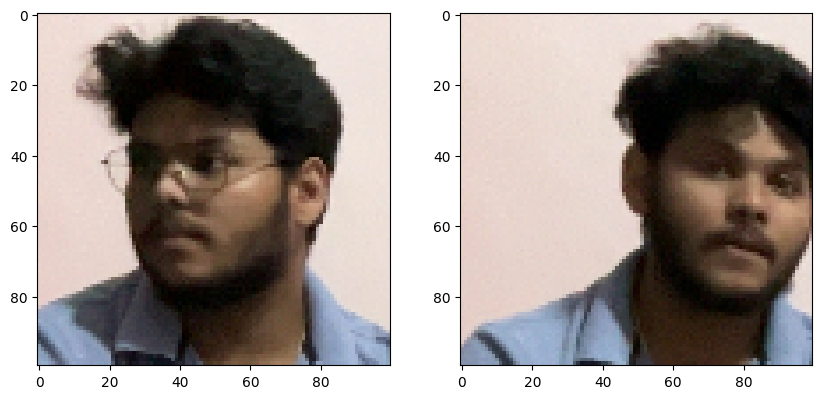

In [108]:
#Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# 7. Save Model


In [109]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [110]:
L1Dist

__main__.L1Dist

In [111]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [112]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 716ms/step


array([[2.7739293e-09],
       [9.9501473e-01],
       [9.9992692e-01],
       [1.0000000e+00],
       [2.2892183e-12],
       [8.4157206e-09],
       [9.9935853e-01],
       [2.6297393e-11],
       [9.9985021e-01],
       [2.5549478e-12],
       [5.2623483e-12],
       [9.9983257e-01],
       [1.1535404e-05],
       [7.1107897e-05],
       [1.0000000e+00],
       [9.9997312e-01]], dtype=float32)

In [113]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [114]:
os.listdir(os.path.join('application_data', 'verification_images'))

['dcf94a7a-1dac-11ee-9b29-e257b528affb.jpg',
 '0eff7a5e-1dac-11ee-9b29-e257b528affb.jpg',
 'f1e48ddc-1dac-11ee-9b29-e257b528affb.jpg',
 '0ed9ebd6-1dac-11ee-9b29-e257b528affb.jpg',
 '0c86b232-1dad-11ee-9b29-e257b528affb.jpg',
 'caf0ce7a-1dac-11ee-9b29-e257b528affb.jpg',
 '0ca1a0c4-1dad-11ee-9b29-e257b528affb.jpg',
 '3349a58c-1dad-11ee-9b29-e257b528affb.jpg',
 '10430de0-1dac-11ee-9b29-e257b528affb.jpg',
 '1609048c-1dac-11ee-9b29-e257b528affb.jpg',
 'f0e1d2be-1dac-11ee-9b29-e257b528affb.jpg',
 'f41a1cf4-1daa-11ee-9b29-e257b528affb.jpg',
 'cbd8e6c4-1dac-11ee-9b29-e257b528affb.jpg',
 'f18d8962-1daa-11ee-9b29-e257b528affb.jpg',
 '0dc0dbd8-1dac-11ee-9b29-e257b528affb.jpg',
 'dc47770a-1dac-11ee-9b29-e257b528affb.jpg',
 'f7df6786-1daa-11ee-9b29-e257b528affb.jpg',
 'ca74d392-1dac-11ee-9b29-e257b528affb.jpg',
 'cc956326-1dac-11ee-9b29-e257b528affb.jpg',
 '19e009e4-1dab-11ee-9b29-e257b528affb.jpg',
 'f0fcfae4-1dac-11ee-9b29-e257b528affb.jpg',
 'dc21b542-1dac-11ee-9b29-e257b528affb.jpg',
 '14015b7a

In [115]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [116]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/dcf94a7a-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/0eff7a5e-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/f1e48ddc-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/0ed9ebd6-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/0c86b232-1dad-11ee-9b29-e257b528affb.jpg
application_data/verification_images/caf0ce7a-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/0ca1a0c4-1dad-11ee-9b29-e257b528affb.jpg
application_data/verification_images/3349a58c-1dad-11ee-9b29-e257b528affb.jpg
application_data/verification_images/10430de0-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/1609048c-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/f0e1d2be-1dac-11ee-9b29-e257b528affb.jpg
application_data/verification_images/f41a1cf4-1daa-11ee-9b29-e257b528affb.jpg
application_data/verification_images/cbd8e6c4-1dac-11ee-9b29-e25

In [117]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [119]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 113ms/step
False
1/1 [==============================] - 0s 113ms/step
True
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 116ms/step
False
1/1 [==============================] - 0s 121ms/step
True
1/1 [==============================] - 0s 116ms/step
False


In [120]:
np.sum(np.squeeze(results) > 0.9)


25

In [121]:
25/60

0.4166666666666667